In [1]:
import os
import numpy as np

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
import optax
import corner
import matplotlib
import matplotlib.pyplot as pl
import corner
import jax
#jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
from functools import partial


import distrax
import haiku as hk
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple
Array = jnp.ndarray
PRNGKey = Array
OptState = Any

In [3]:
from data import gw_fim

class Bivariate_von_Mises:

    def __init__(self, loc,concentration,correlation):
        self.mu, self.nu = loc
        self.k1, self.k2 = concentration
        self.k3 = correlation

    def log_prob(self, x):
        #phi, psi = x.T
        #return self.k1*jnp.cos(phi-self.mu)+self.k2*jnp.cos(psi-self.nu)-self.k3*jnp.cos(phi-self.mu-psi+self.nu)
        return self.k1*jnp.cos(x.T[0]-self.mu)+self.k2*jnp.cos(x.T[1]-self.nu)-self.k3*jnp.cos(x.T[0]-self.mu-x.T[1]+self.nu)
    
    def prob(self, x):
        phi, psi = x.T
        return jnp.exp(self.log_prob(x))
    
class TemplateDensity:
    def __init__(self, param_ripple):
        self.data_tc, self.data_phic = param_ripple


    def log_prob(self, data_x):
        # Local assignment, 2-d param
        # data_x.shape (n, 2)
        data_mc, data_eta = data_x.T
        data_mc = data_mc * 20.0 + 1.0 # 1.0 - 21.0
        data_eta = data_eta * 0.2 + 0.05 # 0.05 - 0.25
        # Param build with shape (n, 4)
        param = gw_fim.fim_param_stack(data_mc, data_eta)
        # Get results with shape (n, )
        result = gw_fim.map_density_plus(param)
        print(f"result.type {type(result)} with dtype {result.dtype}")
        # Func return
        return result


    def prob(self, data_x):
        # Func return - examine log_prob(input), the input may be inverted
        return jnp.exp(self.log_prob(data_x))

In [4]:
loc=[0.0, 0.0]
concentration=[4.0, 4.0]
correlation = 0.
#dist = Bivariate_von_Mises(loc, concentration, correlation)
dist = TemplateDensity([0.0, 0.0])

In [5]:
x = np.array([1,2])
dist.log_prob(x)



/home/theoutsider/.local/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=float64. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/home/theoutsider/.local/lib/python3.10/site-packages/jax/_src/ops/scatter.py:127: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


KeyboardInterrupt: 

In [5]:
dist.log_prob(np.array([[0,1],[0,1]]))

Array([6.161209, 6.161209], dtype=float32)

In [6]:
dist.prob(np.array([0,1]))

Array(474.00085, dtype=float32)

In [9]:
def logprior(theta,theta_min,theta_max):       # pass the parameter location and the parameter bounds
    if np.any(theta-theta_max>0) or np.any(theta_min-theta>0):
        return -np.inf     # if outside the bounds return probability = 0 (log-prob = -infinity)
    return 0.0             # otherwise just return logprob = 0.0

x_min = np.array([1.0, 0.05])
x_max = np.array([21.0, 0.25])

def logprob(x, x_min, x_max):
    return dist.log_prob(x)+logprior(x, x_min, x_max)

In [11]:
import emcee

nwalkers = 16
ndim=2
p0 = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=(x_min, x_max)
                                )
state = sampler.run_mcmc(p0, 1000)
sampler.reset()
sampler.run_mcmc(state, 10000)

emcee: Exception while calling your likelihood function:
  params: [0.56987239 0.9205773 ]
  args: (array([1. , 0.1]), array([21.  ,  0.25]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/theoutsider/.local/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
TypeError: TemplateDensity.log_prob() takes 2 positional arguments but 4 were given


TypeError: TemplateDensity.log_prob() takes 2 positional arguments but 4 were given

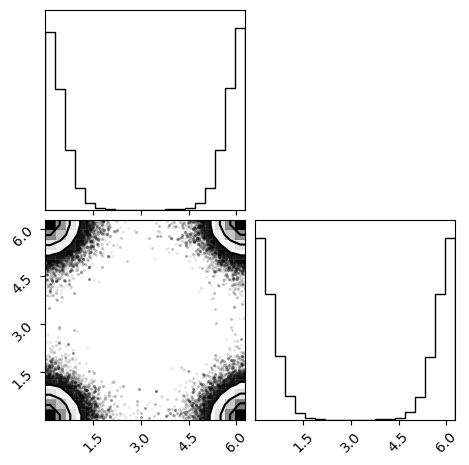

In [44]:
samples = sampler.get_chain(flat=True)
#fig = corner.corner(samples, labels=log_l.params, truths = truths)
fig = corner.corner(samples%(2*np.pi))
pl.show()

In [53]:
samples

array([[-0.3929946 , -0.44103691],
       [-0.62397467, -0.25654519],
       [-0.82104065, -0.95668803],
       ...,
       [-0.27927139, -0.01214343],
       [ 0.61694178, -1.12102342],
       [ 0.48383532,  0.66798488]])

In [14]:

#conditiiner is the NN (parameters of the spline)
def make_conditioner(
    event_shape: Sequence[int],
    hidden_sizes: Sequence[int],
    num_bijector_params: int
) -> hk.Sequential:
  """Creates an."""
  return hk.Sequential([
      hk.Flatten(preserve_dims=-len(event_shape)),
      hk.nets.MLP(hidden_sizes, activate_final=True),
      # We initialize this linear layer to zero so that the flow is initialized
      # to the identity function.
      hk.Linear(
          np.prod(event_shape) * num_bijector_params,
          w_init=jnp.zeros,
          b_init=jnp.zeros),
      hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
  ])

def make_flow_model(
    event_shape: Sequence[int],
    num_layers: int = 4,
    hidden_sizes: Sequence[int] = [250, 250],
    num_bins: int = 4,
) -> distrax.Transformed:
    """Creates the flow model."""
    # Alternating binary mask.
    mask = np.arange(0, np.prod(event_shape)) % 2
    mask = np.reshape(mask, event_shape)
    mask = mask.astype(bool)

    range_min=0.0
    range_max=2*np.pi

    def bijector_fn(params: Array):
        return distrax.RationalQuadraticSpline(
            #params, range_min=0.0, range_max=2*np.pi, boundary_slopes = 'circular'
            params, range_min=0.0, range_max=2*np.pi
        )

    # Number of parameters for the rational-quadratic spline:
    # - `num_bins` bin widths
    # - `num_bins` bin heights
    # - `num_bins + 1` knot slopes
    # for a total of `3 * num_bins + 1` parameters.
    num_bijector_params = 3 * num_bins + 1

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask,
            bijector=bijector_fn,
            conditioner=make_conditioner(event_shape, hidden_sizes,
                                        num_bijector_params))
        layers.append(layer)
        # Flip the mask after each layer.
        mask = jnp.logical_not(mask)

    # We invert the flow so that the `forward` method is called with `log_prob`.
    flow = distrax.Inverse(distrax.Chain(layers))                                   #bijective transformation from base (normal) to parameter space 
    base_distribution = distrax.Independent(
        #distrax.Uniform(low=jnp.ones(event_shape)*-1, high=jnp.ones(event_shape)*1),
        distrax.Uniform(low=jnp.ones(event_shape)*range_min, high=jnp.ones(event_shape)*range_max),
        #distrax.Normal(loc=jnp.zeros(event_shape), scale=jnp.ones(event_shape)),
        reinterpreted_batch_ndims=len(event_shape)
    )

    return distrax.Transformed(base_distribution, flow)




#class SplineParams(hk.Module):
#    def __init__(self, output_size, name=None):
#        super().__init__(name=name)
#        self.output_size=output_size
#    def __call__(self):
#        y = hk.get_parameter("spline_weights",
#                             (1,self.output_size),
#                             init=jnp.zeros)
#        return y



#def make_flow_model(
#    event_shape: Sequence[int],
#    num_layers: int = 4,                      #not used for 1D 
#    hidden_sizes: Sequence[int] = [16, 16],   #not used for 1D
#    num_bins: int = 4,
#) -> distrax.Transformed:
    """Creates the flow model."""
    # Alternating binary mask.
    #mask = jnp.arange(0, jnp.prod(event_shape)) % 2
    #mask = jnp.reshape(mask, event_shape)
    #mask = mask.astype(bool)
    #mask = jnp.array([False,])
#    range_min=-np.pi
#    range_max=np.pi
    # def bijector_fn(params: Array):
    #     return distrax.RationalQuadraticSpline(
    #         params, range_min=range_min, range_max=range_max
    #     )
    
    # Number of parameters for the rational-quadratic spline:
    # - `num_bins` bin widths
    # - `num_bins` bin heights
    # - `num_bins + 1` knot slopes
    # for a total of `3 * num_bins + 1` parameters.
#    num_bijector_params = 3 * num_bins + 1

    # We invert the flow so that the `forward` method is called with `log_prob`.
    #flow = distrax.Inverse(distrax.Chain(layers))
#    base_distribution = distrax.Independent(
        ## For 1 dimension#
 #       distrax.Uniform(low=jnp.ones(event_shape)*range_min, high=jnp.ones(event_shape)*range_max),
        ## For 2+ dimensions
        #distrax.Normal(loc=jnp.zeros(event_shape), scale=jnp.ones(event_shape)),
        #reinterpreted_batch_ndims=len(event_shape)
 #   )

    ## For affine transformation
    # def bijector_fn():
    #     scale = hk.get_parameter("scale",event_shape,init=jnp.ones)
    #     shift = hk.get_parameter("shift",event_shape,init=jnp.zeros)
    #     bijector = distrax.ScalarAffine(shift=shift,scale=scale)
    #     return bijector
    
    ## For spline
  #  params = SplineParams(num_bijector_params)
  #  def bijector_fn():
  #      params = hk.get_parameter("spline_weights",
   #                          (n_params,num_bijector_params),
   #                          init=jnp.zeros)
  #      bijector = distrax.RationalQuadraticSpline(params,range_min, range_max, boundary_slopes='circular')
  #      return bijector

  #  bijector = distrax.Block(bijector_fn(), n_params)

  #  return distrax.Transformed(base_distribution, bijector)


@hk.without_apply_rng
@hk.transform
def sample_and_log_prob(prng_key: PRNGKey, n: int) -> Tuple[Any, Array]:
    event_shape=(n_params,)

    model = make_flow_model(
        event_shape=event_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )
    return model.sample_and_log_prob(seed=prng_key, sample_shape=(n,))

@hk.without_apply_rng
@hk.transform
def flow_prob(x: Array) -> Array:
    event_shape=(n_params,)

    model = make_flow_model(
        event_shape=event_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )
    return model.prob(x)

def loss_fn(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:

    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)
    log_p = dist.log_prob(x_flow)
      
    loss = jnp.mean(log_q - log_p)
    return loss


#@jax.jit
def update(
    params: hk.Params,
    prng_key: PRNGKey,
    opt_state: OptState,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, Nsamps)
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

  0%|          | 0/100 [00:00<?, ?it/s, loss=-3.85]

Epoch 0, loss -3.8523857593536377


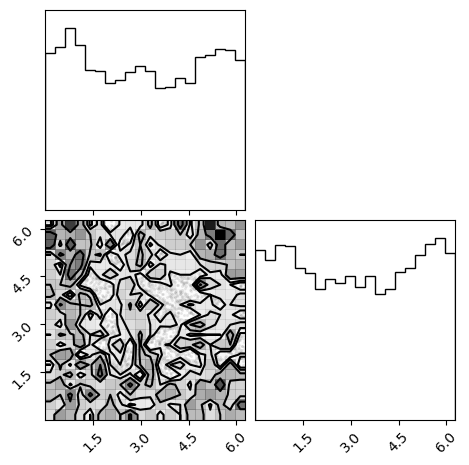

 20%|██        | 20/100 [00:07<00:27,  2.87it/s, loss=-7.57]

Epoch 20, loss -7.572225093841553


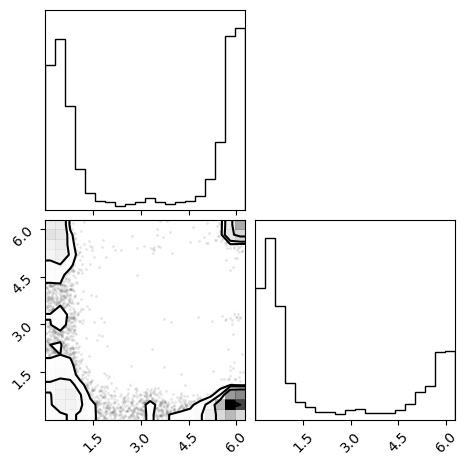

 40%|████      | 40/100 [00:15<00:21,  2.85it/s, loss=-8.00]

Epoch 40, loss -7.997251033782959


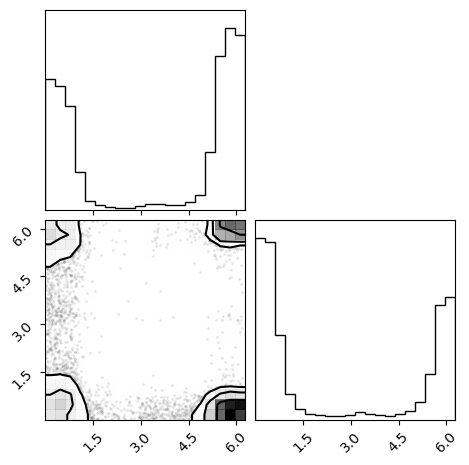

 60%|██████    | 60/100 [00:22<00:14,  2.84it/s, loss=-8.21]

Epoch 60, loss -8.21049976348877


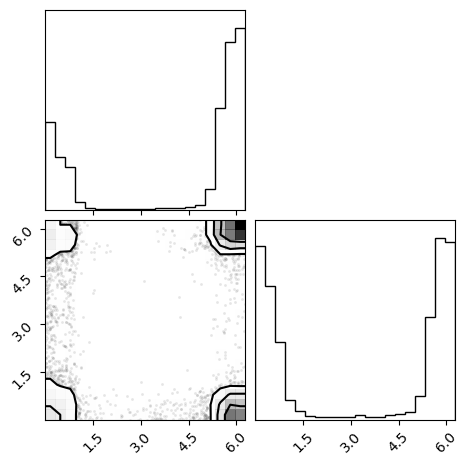

 80%|████████  | 80/100 [00:30<00:07,  2.66it/s, loss=-8.34]

Epoch 80, loss -8.337103843688965


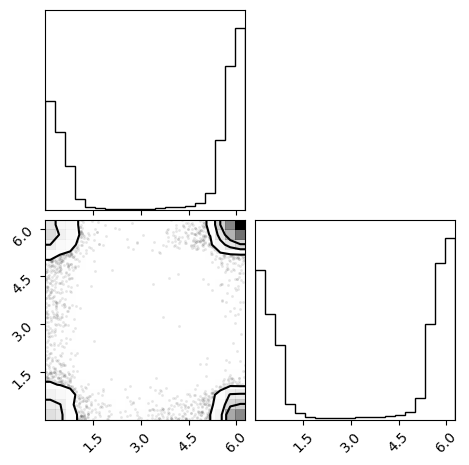

100%|██████████| 100/100 [00:39<00:00,  2.56it/s, loss=-8.43]

Done!


In [16]:

if __name__ == '__main__':


    n_params = 2
    flow_num_layers = 2
    hidden_size = 8
    mlp_num_layers = 2
    num_bins = 4

    # perform variational inference
    epochs = 100
    loss = dict(train=[], val=[])
    Nsamps = 1000

    learning_rate = 0.01
    optimiser = optax.adam(learning_rate)

    prng_seq = hk.PRNGSequence(42)
    key = next(prng_seq)
    params = sample_and_log_prob.init(key, prng_key=key, n=Nsamps)
    opt_state = optimiser.init(params)

    from tqdm import tqdm, trange
    ldict = dict(loss = 0)
    losses = []
    flows = []
    with trange(epochs) as tepochs:
        for epoch in tepochs:
            prng_key = next(prng_seq)
            loss = loss_fn(params,  prng_key, Nsamps)
            ldict['loss'] = f'{loss:.2f}'
            losses.append(loss)
            tepochs.set_postfix(ldict, refresh=True)
            params, opt_state = update(params, prng_key, opt_state)

            if epoch%20 == 0:
                print(f'Epoch {epoch}, loss {loss}')
                x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)
                samples = np.array(x_gen)
                fig = corner.corner(samples)
                flows.append(samples)
                pl.show()
            #    x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)
            #    fig = plt.figure(figsize=(4,2))
            #    ax = fig.gca()
            #    ax.hist(x_gen.squeeze().T,50)
            #    mu = x_gen.mean()
            #    sigma = jnp.sqrt(jnp.mean((x_gen - mu)**2))
            #    ldict['mu'] = mu
            #    ldict['sigma'] = sigma
            #    ax.set_title(f'mean: {mu:.2f}, sigma={sigma:.2f}')
                #xvec = jnp.arange(x_gen.min(), x_gen.max(), 0.1)
                #lp_params = log_prob.init(key, prng_key=key, x=xvec)
                #plt.plot(xvec, log_prob.apply(lp_params, next(prng_seq), x=xvec))
            #    plt.show()
            #    plt.close(fig)
                
            #    fig  = plt.figure(figsize=(2,1))
            #    ax = fig.gca()
            #    ax.semilogy(jnp.array(losses)-jnp.min(jnp.array(losses)))
            #    ax.set_title('Loss')
            #    ax.set_ylabel('loss')
            #    ax.set_xlabel('iteration')
            #    plt.show()
            #    plt.close(fig)



    print("Done!")

    #x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 100*Nsamps)
    #plt.hist(x_gen.squeeze().T,50)
    #plt.show()
    #plt.savefig(f'posterior_{epochs}.png')

In [17]:
x_gen

Array([[5.811787  , 0.8692746 ],
       [5.6842732 , 0.8852447 ],
       [0.5085403 , 0.35437912],
       ...,
       [5.8825655 , 0.07927123],
       [5.7749515 , 0.20385453],
       [0.69806725, 4.891261  ]], dtype=float32)

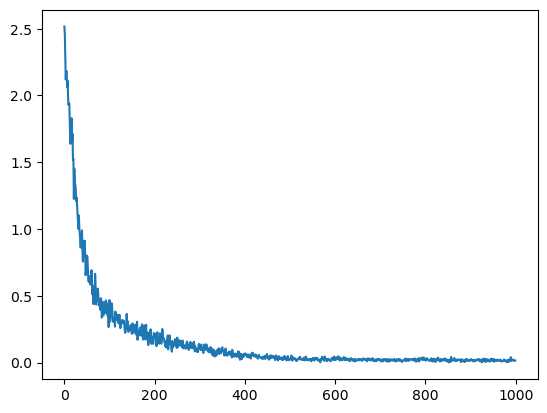

In [ ]:
pl.plot(losses)

In [ ]:

fig = None

    # Need to update colours for 1D and 2D plots
    kwargs["color"] = "C0"
    kwargs["hist_kwargs"]["color"] = "C0"
    fig = corner.corner(samples, fig=fig, **kwargs)

    kwargs["color"] = "C1"
    kwargs["hist_kwargs"]["color"] = "C1"
    fig = corner.corner(p_gen.T, labels=log_l.params, truths = truths, fig=fig, **kwargs)

    pl.savefig(f'results/{run_name}/posterior_comparison_{epochs}.png')
    pl.close()

NameError: name 'log_prob' is not defined

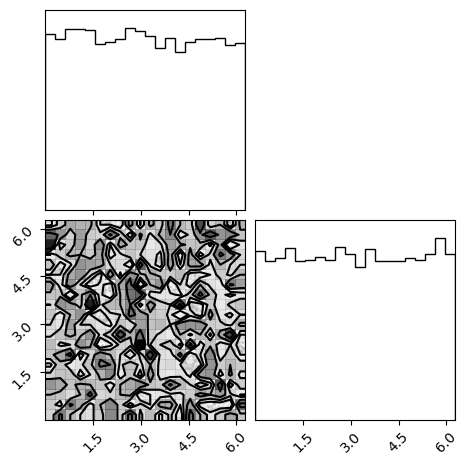

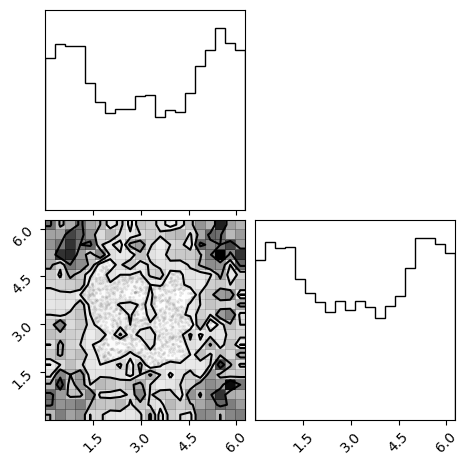

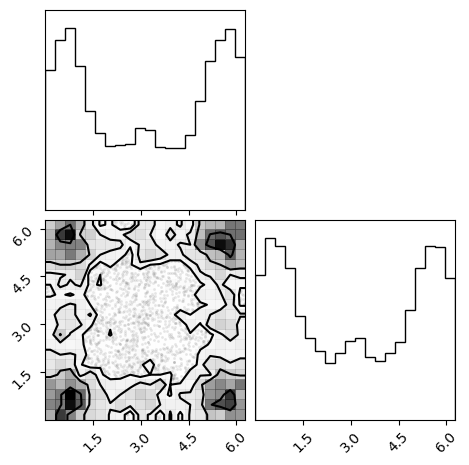

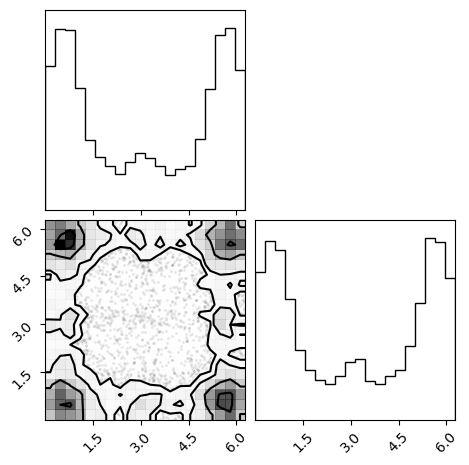

In [94]:
from PIL import Image, ImageDraw
import io


#lt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True

#plt.figure()
#plt.plot([1, 2])



def make_gif(flows):
    frames = []
    for i in range(4):
        fig = corner.corner(flows[i])
        img_buf = io.BytesIO()
        pl.savefig(img_buf, format='png')
        im = Image.open(img_buf)
        frames.append(im)
        #img_buf.close()
        
    frame_one = frames[0]

    frame_one.save("circle.gif", format="GIF", append_images=frames,
                   save_all=True, duration=100, loop=0)
    
if __name__ == "__main__":
    make_gif(flows)

In [85]:
frames[0]

NameError: name 'frames' is not defined

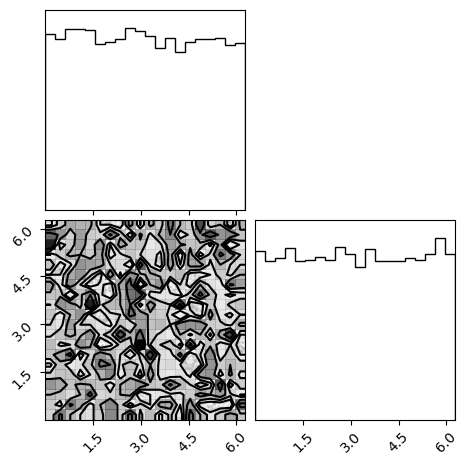

In [81]:
fig